In [1]:
import tensorflow as tf
import scipy.io as sio
import numpy as np
import glob
from time import time
from PIL import Image
import math
import matplotlib.pyplot as plt

Load Data
(531, 64)
(531, 64)
(90270, 697)


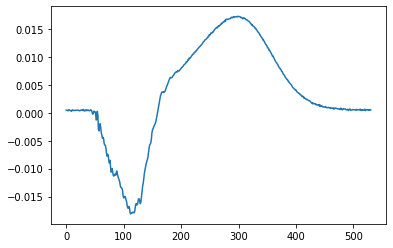

In [2]:
cpkt_model_number = 1000
n_input = 64
n_output = 697
batch_size = 256
PhaseNumber = 3
nrtrain = 90270
learning_rate = 0.00001
EpochNum = 1000

print('Load Data')
# load H matrix
H_matrix_path = 'D:/research/data/ECGSimdata/H.mat'
Phi_input = sio.loadmat(H_matrix_path)['H'].T
# load TMP
TMP_path = 'D:/research/data/ECGSimdata/data/Tmp/tmp_42.mat'
TMP = sio.loadmat(TMP_path)['tmp'].T
test_tmp = TMP / 85

# Training_inputs  = np.dot(test_tmp, Phi_input)
Training_inputs = sio.loadmat('D:/research/MICCAI2020/results/simulation2/IISTA13/bsp.mat')['bsp'].T / 85
plt.plot(Training_inputs[:,1])
# path = 'D:/research/data/ECGSimdata/bsp1.mat'
# bsp = sio.loadmat(path)['bsp'].T
# Training_inputs = bsp / 85
# plt.plot(Training_inputs[:,1])
print(Training_inputs.shape)

train_label_path = 'D:/research/data/ECGSimdata/TMP.mat'
Training_labels = sio.loadmat(train_label_path)['TMP'].T
Training_labels = Training_labels / 85
# TMP = TMP.reshape(257, 505, 1000)
# # load bsp
# bsp_path = 'D:/research/data/ECGSimdata/BSP.mat'
# bsp = sio.loadmat(bsp_path)['BSP'].T
# Training_inputs = bsp 
# print(Training_inputs.shape)

# load test data
# test_path = 'D:/research/data/ECGSimdata/data/bsp64/bsp64_42.mat'
# Training_inputs = sio.loadmat(test_path)['bsp'].T
# Training_inputs  = np.dot(test_tmp, Phi_input)
print(Training_inputs.shape)
print(Training_labels.shape)

In [3]:
# Computing Initialization Matrix
XX = Training_labels.transpose()
BB = np.dot(Phi_input.transpose(), XX)
BBB = np.dot(BB, BB.transpose())
CCC = np.dot(XX, BB.transpose())
PhiT_ = np.dot(CCC, np.linalg.inv(BBB))
del XX, BB, BBB
PhiInv_input = PhiT_.transpose()
PhiTPhi_input = np.dot(Phi_input, Phi_input.transpose())

In [4]:
Phi = tf.constant(Phi_input, dtype=tf.float32)
PhiTPhi = tf.constant(PhiTPhi_input, dtype=tf.float32)
PhiInv = tf.constant(PhiInv_input, dtype=tf.float32)

X_input = tf.placeholder(tf.float32, [None, n_input])
X_output = tf.placeholder(tf.float32, [None, n_output])


X0 = tf.matmul(X_input, PhiInv)

PhiTb = tf.matmul(X_input, tf.transpose(Phi))

In [5]:
def add_con2d_weight_bias(w_shape, b_shape, order_no):
    Weights = tf.get_variable(shape=w_shape, initializer=tf.contrib.layers.xavier_initializer_conv2d(), name='Weights_%d' % order_no)
    biases = tf.Variable(tf.random_normal(b_shape, stddev=0.05), name='biases_%d' % order_no)
    return [Weights, biases]


def ista_block(input_layers, input_data, layer_no):
    tau_value = tf.Variable(0.1, dtype=tf.float32)
    lambda_step = tf.Variable(0.1, dtype=tf.float32)
    soft_thr = tf.Variable(0.1, dtype=tf.float32)
    conv_size = 32
    filter_size = 3

    x1_ista = tf.add(input_layers[-1] - tf.scalar_mul(lambda_step, tf.matmul(input_layers[-1], PhiTPhi)), tf.scalar_mul(lambda_step, PhiTb))  # X_k - lambda*A^TAX

    x2_ista = tf.reshape(x1_ista, shape=[-1, 17, 41, 1])


    [Weights0, bias0] = add_con2d_weight_bias([filter_size, filter_size, 1, conv_size], [conv_size], 0)

    [Weights1, bias1] = add_con2d_weight_bias([filter_size, filter_size, conv_size, conv_size], [conv_size], 1)
    [Weights11, bias11] = add_con2d_weight_bias([filter_size, filter_size, conv_size, conv_size], [conv_size], 11)

    [Weights2, bias2] = add_con2d_weight_bias([filter_size, filter_size, conv_size, conv_size], [conv_size], 2)
    [Weights22, bias22] = add_con2d_weight_bias([filter_size, filter_size, conv_size, conv_size], [conv_size], 22)


    [Weights3, bias3] = add_con2d_weight_bias([filter_size, filter_size, conv_size, 1], [1], 3)


    x3_ista = tf.nn.conv2d(x2_ista, Weights0, strides=[1, 1, 1, 1], padding='SAME')

    x4_ista = tf.nn.relu(tf.nn.conv2d(x3_ista, Weights1, strides=[1, 1, 1, 1], padding='SAME'))
    x44_ista = tf.nn.conv2d(x4_ista, Weights11, strides=[1, 1, 1, 1], padding='SAME')

    x5_ista = tf.multiply(tf.sign(x44_ista), tf.nn.relu(tf.abs(x44_ista) - soft_thr))

    x6_ista = tf.nn.relu(tf.nn.conv2d(x5_ista, Weights2, strides=[1, 1, 1, 1], padding='SAME'))
    x66_ista = tf.nn.conv2d(x6_ista, Weights22, strides=[1, 1, 1, 1], padding='SAME')

    x7_ista = tf.nn.conv2d(x66_ista, Weights3, strides=[1, 1, 1, 1], padding='SAME')

    x7_ista = x7_ista + x2_ista

    x8_ista = tf.reshape(x7_ista, shape=[-1, 697])

    x3_ista_sym = tf.nn.relu(tf.nn.conv2d(x3_ista, Weights1, strides=[1, 1, 1, 1], padding='SAME'))
    x4_ista_sym = tf.nn.conv2d(x3_ista_sym, Weights11, strides=[1, 1, 1, 1], padding='SAME')
    x6_ista_sym = tf.nn.relu(tf.nn.conv2d(x4_ista_sym, Weights2, strides=[1, 1, 1, 1], padding='SAME'))
    x7_ista_sym = tf.nn.conv2d(x6_ista_sym, Weights22, strides=[1, 1, 1, 1], padding='SAME')

    x11_ista = x7_ista_sym - x3_ista

    return [x8_ista, x11_ista]


def inference_ista(input_tensor, n, X_output, reuse):
    layers = []
    layers_symetric = []
    layers.append(input_tensor)
    for i in range(n):
        with tf.variable_scope('conv_%d' %i, reuse=reuse):
            [conv1, conv1_sym] = ista_block(layers, X_output, i)
            layers.append(conv1)
            layers_symetric.append(conv1_sym)
    return [layers, layers_symetric]



[Prediction, Pre_symetric] = inference_ista(X0, PhaseNumber, X_output, reuse=False)

cost0 = tf.reduce_mean(tf.square(X0 - X_output))


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
def compute_cost(Prediction, X_output, PhaseNumber):
    cost = tf.reduce_mean(tf.square(Prediction[-1] - X_output))
    cost_sym = 0
    for k in range(PhaseNumber):
        cost_sym += tf.reduce_mean(tf.square(Pre_symetric[k]))

    return [cost, cost_sym]


[cost, cost_sym] = compute_cost(Prediction, X_output, PhaseNumber)

cost_all = cost + 0.01*cost_sym


optm_all = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost_all)

init = tf.global_variables_initializer()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

saver = tf.train.Saver(tf.global_variables(), max_to_keep=100)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./Phase_3_ISTA_Net_plus_Model/CS_Saved_Model_1000.cpkt


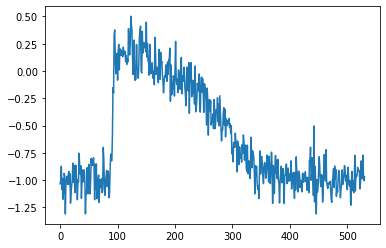

In [7]:
sess = tf.Session(config=config)
model_dir = 'Phase_%d_ISTA_Net_plus_Model' % PhaseNumber
saver.restore(sess, './%s/CS_Saved_Model_%d.cpkt' % (model_dir, cpkt_model_number))
Img_input = Training_inputs
start = time()
Prediction_value = sess.run(Prediction[-1], feed_dict={X_input: Img_input})
X_initialize = sess.run(X0, feed_dict = {X_input: Img_input})
end = time()

plt.plot(X_initialize[:,1])

(531, 697)


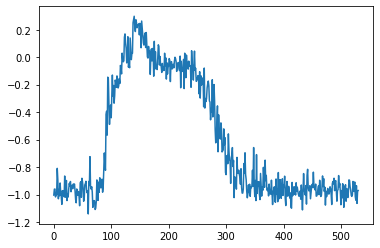

In [8]:
print(Prediction_value.shape)
plt.plot(Prediction_value[:,1])
data = 'D://research/data/ECGSimdata/init_tmp.mat.'

sio.savemat(data, {'tmp_i':X_initialize})

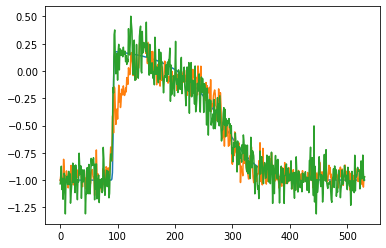

In [9]:
plt.plot(test_tmp[:,1])
plt.plot(Prediction_value[:,1])
plt.plot(X_initialize[:,1])
plt.show()
dataNew = 'D://research/data/ECGSimdata/recons_tmp.mat.'

sio.savemat(dataNew, {'tmp_r':Prediction_value})